## We will use Cats Vs Dog Dataset and create custom model to convert to Tflite.


In [1]:
import numpy as np
import matplotlib.pyplot as plt##visualisation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dense, Dropout
##Datasets
import tensorflow_datasets as tfds

### Lets Load cats vs dogs datasets

In [2]:
cats_dogs, info= tfds.load('cats_vs_dogs', with_info=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteBYIKD4/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

### Dataset Splitting
We have around 20K samples, we will shuffle the dataset and will split it.


In [4]:
train_dataset= cats_dogs['train']

###Sample image

(262, 350, 3)


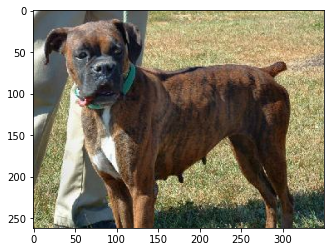

In [5]:
for samp in train_dataset.take(1):
  print(samp['image'].shape)
  plt.imshow(samp['image'])

## Normalization

In [6]:
## We will resize the image to a common shape and normalize the values.
train_dataset= train_dataset.map(lambda image:
                                 (tf.image.resize(image['image'], (224,224))/255, image['label']),
                                 num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [7]:
### Lets create batch size and shuffle the dataset.
train_dataset= train_dataset.shuffle(10000).batch(batch_size=32).prefetch(1)
train_datset= train_dataset.cache()

### Craete Train and test datasets

In [8]:
test_dataset= train_dataset.skip(7500)
train_dataset= train_dataset.take(7500)

### Model Creation
#### We will build model with CNN

In [9]:
model= keras.Sequential()
model.add(Conv2D(filters=16, kernel_size=(2,2), strides=(1,1), activation='relu', padding='SAME',
                 input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(2,2), strides=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters= 64, kernel_size=(2,2), strides=(2,2), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), activation='relu'))
model.add(GlobalMaxPooling2D())
model.add(Dense(units= 64, activation='relu' ))
model.add(Dropout(rate=0.3))
model.add(Dense(units= 2))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 111, 111, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 64)        8256      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        16448     
_________________________________________________________________
global_max_pooling2d (Global (None, 64)                0

In [10]:
model.compile(optimizer= tf.optimizers.Adam(lr= 0.0001),
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics='accuracy' )

In [11]:
###Lets train model
model.fit(train_dataset, epochs=10, validation_data= test_dataset)

Epoch 1/10
727/727 [==============================] - 81s 111ms/step - loss: 0.6866 - accuracy: 0.5515
Epoch 2/10
727/727 [==============================] - 41s 56ms/step - loss: 0.6538 - accuracy: 0.6232
Epoch 3/10
727/727 [==============================] - 40s 56ms/step - loss: 0.6253 - accuracy: 0.6532
Epoch 4/10
727/727 [==============================] - 40s 55ms/step - loss: 0.6041 - accuracy: 0.6734
Epoch 5/10
727/727 [==============================] - 40s 55ms/step - loss: 0.5882 - accuracy: 0.6891
Epoch 6/10
727/727 [==============================] - 41s 56ms/step - loss: 0.5772 - accuracy: 0.6982
Epoch 7/10
727/727 [==============================] - 40s 56ms/step - loss: 0.5665 - accuracy: 0.7082
Epoch 8/10
727/727 [==============================] - 40s 56ms/step - loss: 0.5579 - accuracy: 0.7143
Epoch 9/10
727/727 [==============================] - 41s 56ms/step - loss: 0.5498 - accuracy: 0.7198
Epoch 10/10
727/727 [==============================] - 40s 55ms/step - loss: 0.54

## Model Saving
We've got the model now. Lets save it!!

In [12]:
export_dir='/content/drive/My Drive/Computer Vision Interview/Tensorflow Lite/Tf lite files'
tf.saved_model.save(model, export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /content/drive/My Drive/Computer Vision Interview/Tensorflow Lite/Tf lite files/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Computer Vision Interview/Tensorflow Lite/Tf lite files/assets


### Tensorflow Lite Conversion
We have created Tf model. Now we will convert to Tflite.
#### Tf Lite Versions:
while Converting to Tflite version. Model has to udergo Quantization optimization.
#### Quantization
Reduction of Size and Latency is the main aim of Quantization, which improves speed and consumes low RAM in edge devices. Below are few types of quantization.



1.   Post Training Quantization
2.   Post Training with Dynamic Range Quantization
3.   Post training integer quantization
4.   Post Training Float16 Quantization


We will create each type with our saved model and test Tflite model using Tensorflow Python interpreter.



## Post Training Quantization

In [10]:
### Lets create converter for tensorflow model.
import_dir='/content/drive/My Drive/Computer Vision Interview/Tensorflow Lite/Tf lite files/pretrain.hd5'

converter= tf.lite.TFLiteConverter.from_saved_model(import_dir)


### We can optimize model in two ways


*   Size
*   latency
*   Both

We will select both in this case.





In [11]:
converter.optimizations=[tf.lite.Optimize.DEFAULT]
###Convert the model
tf_lite_quant= converter.convert()

### Now we have converted the model.
Lets save it in the drive.

In [12]:
import pathlib
tf_lite_path=pathlib.Path('/content/drive/My Drive/Computer Vision Interview/Tensorflow Lite/Tf lite files/tf lite files/tf_lite_quant.tflite')

In [13]:
### We will write bytes to the above path
tf_lite_path.write_bytes(tf_lite_quant)

3625280

## Quantization summary:


---



*   Pre-quantization: size ~15 MB
*   Post-Quantization: Size = 3MB

The size has drastically reduced.





### Post-training Dynamic range Quantization
Here the reduction of size or conversion of datatypes happens along with dynamic inputs passing to the converter as representative data. Representative data helps in evaluating scores of neurons.

In [49]:
### Dataset creation for representative data
representative_dataset= cats_dogs['train']
representative_dataset=representative_dataset.map(lambda image :
                                                  (tf.image.resize(image['image'], (224,224))/255, image['label']))

In [14]:
### Lets create converter for tensorflow model.
import_dir='/content/drive/My Drive/Computer Vision Interview/Tensorflow Lite/Tf lite files/pretrain.hd5'

converter= tf.lite.TFLiteConverter.from_saved_model(import_dir)
## Select optimizer
converter.optimizations=[tf.lite.Optimize.DEFAULT]

In [17]:
## We will create function which yields image as representative data
def represent_data():
  for rep_image in  representative_dataset.batch(1).take(100):
    yield [rep_image[0]]

converter.representative_dataset=represent_data

In [19]:
### This conversion is post training Dynamic quantization
tf_lite_dynamic_quant= converter.convert()

### Lets save it in drive
The size is little large compared with Post Training Quantization as we are evaluating using Representative data.

In [20]:
tf_lite_path=pathlib.Path('/content/drive/My Drive/Computer Vision Interview/Tensorflow Lite/Tf lite files/tf lite files/tf_lite_dynamic_quant.tflite')
tf_lite_path.write_bytes(tf_lite_dynamic_quant)

4162976

### Post Training Integer Quantization
We will convert the dtatype of weights from float32 to int8.
 This is because some edge devices are integer compactible. So tf has an option to convert the weights from Fp32 to int8.
#### Even the Size has drastically reduced from 4 MB to 1 MB

In [29]:
### Lets create converter for tensorflow model.
import_dir='/content/drive/My Drive/Computer Vision Interview/Tensorflow Lite/Tf lite files/pretrain.hd5'

converter= tf.lite.TFLiteConverter.from_saved_model(import_dir)
## Select optimizer
converter.optimizations=[tf.lite.Optimize.DEFAULT]
converter.representative_dataset= represent_data
## Lets add the conversion
converter.target_spec.supported_ops=[tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type= tf.uint8
converter.inference_output_type= tf.uint8
tf_lite_int_quant= converter.convert()

##

In [ ]:
import pathlib
tf_lite_path=pathlib.Path('/content/drive/My Drive/Computer Vision Interview/Tensorflow Lite/Tf lite files/tf lite files/tf_lite_integer_quant.tflite')
tf_lite_path.write_bytes(tf_lite_int_quant)

Post Training float16 Quantization is also similar to integer quantization except the value 


```
converter.target_spec.supported_ops=[tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
```

 should be replaced with 
```
converter.target_spec.supported_ops=[tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
```

### Post conversion, we can test our model in our system itself using Tensorflow python interpreter which is a very useful tool for people who doesn't have edge devices with them.

In [32]:
interpreter= tf.lite.Interpreter(model_content=tf_lite_int_quant)

## We will chcek the input and output details of the interpreter

In [34]:
interpreter.get_input_details()

[{'dtype': numpy.uint8,
  'index': 179,
  'name': 'input_1',
  'quantization': (0.003921568859368563, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([0.00392157], dtype=float32),
   'zero_points': array([0], dtype=int32)},
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [35]:
interpreter.get_output_details()

[{'dtype': numpy.uint8,
  'index': 180,
  'name': 'Identity',
  'quantization': (0.00390625, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([0.00390625], dtype=float32),
   'zero_points': array([0], dtype=int32)},
  'shape': array([   1, 1000], dtype=int32),
  'shape_signature': array([  -1, 1000], dtype=int32),
  'sparsity_parameters': {}}]

### Before Predicting we have few variables to consider


*   index Values of input and output: While getting and setting tensors
*   Data Type of input and output : we will assign to interpreter
*   quantization weights and bias: we will divide the image values with quantization weights and add the bias




In [36]:
## Get indexes
input_index= interpreter.get_input_details()[0]['index']
output_index= interpreter.get_output_details()[0]['index']
## Get the Data type of input
input_dtype= interpreter.get_input_details()[0]['dtype']
### Get the Weight quantizer and bias
quant_weight= interpreter.get_input_details()[0]['quantization'][0]
quant_bias= interpreter.get_input_details()[0]['quantization'][1]

In [50]:
#Pre process the image
for sample_data in representative_dataset.take(1):
  sample_image= sample_data[0]


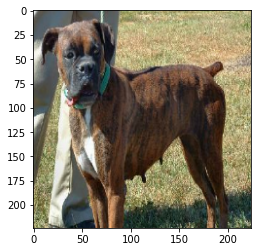

In [51]:
plt.imshow(sample_image)

In [52]:
sample_image.shape

TensorShape([224, 224, 3])

In [55]:
### Now lets quantize the image
sample_image= (sample_image/quant_weight )+ quant_bias
## Expand dims
sample_image= np.expand_dims(sample_image, axis=0).astype(input_dtype)

In [58]:
## Allocate tensors
interpreter.allocate_tensors()
## Les set the tensors
interpreter.set_tensor( input_index, sample_image)
## invoke the interpreter to predict
interpreter.invoke()

In [59]:
### lets check the prediction
prediction= interpreter.get_tensor(output_index)